In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset, concatenate_datasets, Dataset

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import numpy as np
import pandas as pd 

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

import evaluate 

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay


In [2]:
generated_ppms = pd.read_csv(paths.DATA_PATH_PREPROCESSED/'ms-diag/artificial_ppms.csv')
generated_ppms["labels"] = 'primary_progressive_multiple_sclerosis'
generated_spms = pd.read_csv(paths.DATA_PATH_PREPROCESSED/'ms-diag/artificial_spms.csv')
generated_spms["labels"] = 'secondary_progressive_multiple_sclerosis'
generated_samples = pd.concat([generated_ppms, generated_spms])
generated_samples = generated_samples[["0", "labels"]].rename(columns = {"0":"text"})
generated_samples = Dataset.from_pandas(generated_samples).remove_columns('__index_level_0__')

In [3]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
df["train"] = concatenate_datasets([generated_samples, df["train"]])

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {'primary_progressive_multiple_sclerosis': 0,
            'relapsing_remitting_multiple_sclerosis': 1,
            'secondary_progressive_multiple_sclerosis': 2}
id2label = {v:k for k,v in label2id.items()}

In [4]:
# Subsample stratisfied by label
df['train'] = concatenate_datasets([df['train'].filter(lambda example: example['labels'] == 'primary_progressive_multiple_sclerosis'), 
                                     df['train'].filter(lambda example: example['labels'] == 'secondary_progressive_multiple_sclerosis'),
                                     df['train'].filter(lambda example: example['labels'] == "relapsing_remitting_multiple_sclerosis").select(range(0,20))])

In [5]:
# # Run this cell if you want to download and fine-tune the model
# from huggingface_hub import notebook_login

# # Login to Hugging Face Hub as model is gated
# notebook_login()

# # Checkpoint
# checkpoint = "GerMedBERT/medbert-512"

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# # Save tokenizer
# tokenizer.save_pretrained(paths.MODEL_PATH/'medbert')

# # Load model for embedding
# model = AutoModel.from_pretrained(checkpoint)

# # Save model
# model.save_pretrained(paths.MODEL_PATH/'medbert')

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    # data["text"] = [text[:256] for text in data["text"]]
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt')

    return data

# Tokenize dataset
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

In [8]:
# Training arguments
EPOCHS = 12
BATCH_SIZE = 16
TRAIN_STEPS = EPOCHS * len(dataset['train']) // BATCH_SIZE

# Collator
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

# Dataloader
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Accelerator
accelerator = Accelerator(mixed_precision='fp16')

# Optimizer and scheduler
optim = AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    "linear",
    optim,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

#f1_metric = evaluate.load("f1")

# Class weights
power = 1
class_weights = [1/np.log(len(dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(dataset['train']['labels'])]
class_weights = [weight**power for weight in class_weights]
class_weights = torch.tensor(class_weights, dtype=torch.float)


loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

# Prepare with accelerator
model, optim, train_loader, val_loader, test_loader, loss_fun = accelerator.prepare(
    model, optim, train_loader, val_loader, test_loader, loss_fun
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
class_weights

tensor([0.1952, 0.3338, 0.2149])

In [10]:
# Training
torch.manual_seed(42)
progress_bar = tqdm.tqdm(range(TRAIN_STEPS))

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        outputs = model(**batch)
        # loss = loss_fun(outputs.logits, batch['labels'])
        loss = outputs.loss
        accelerator.backward(loss)
        optim.step()
        lr_scheduler.step()
        progress_bar.update(1)

    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        val_loss = 0
        acc = 0
        for batch in val_loader:
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            
            val_loss += loss_fun(outputs.logits, batch['labels'])
            acc += (predictions == batch['labels']).sum().item()
            
            preds.extend(predictions.tolist())
            labels.extend(batch['labels'].tolist())

    f1 = f1_score(labels, preds, average='weighted')
    if epoch == 0:
            min_val_loss = val_loss
    elif epoch >= 5 & (val_loss < min_val_loss):
        min_val_loss = val_loss
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert')

    print(f"Epoch {epoch+1}: F1 score: {f1} Loss: {val_loss/len(val_loader)} Accuracy: {acc/len(dataset['validation'])}")

  8%|▊         | 18/219 [00:05<00:53,  3.77it/s]

Epoch 1: F1 score: 0.34523809523809523 Loss: 1.2807199954986572 Accuracy: 0.2857142857142857


 17%|█▋        | 38/219 [00:10<00:38,  4.72it/s]

Epoch 2: F1 score: 0.5142857142857142 Loss: 1.1551012992858887 Accuracy: 0.42857142857142855


 26%|██▌       | 57/219 [00:16<00:34,  4.70it/s]

Epoch 3: F1 score: 0.7542857142857142 Loss: 0.4595195949077606 Accuracy: 0.7857142857142857


 35%|███▍      | 76/219 [00:22<00:30,  4.67it/s]

Epoch 4: F1 score: 0.7542857142857142 Loss: 0.5554262399673462 Accuracy: 0.7857142857142857


 43%|████▎     | 95/219 [00:28<00:26,  4.65it/s]

Epoch 5: F1 score: 0.7810559006211181 Loss: 0.6601940989494324 Accuracy: 0.7857142857142857


 52%|█████▏    | 114/219 [00:34<00:22,  4.57it/s]

Epoch 6: F1 score: 0.822857142857143 Loss: 0.36326083540916443 Accuracy: 0.8571428571428571


 61%|██████    | 133/219 [00:40<00:18,  4.61it/s]

Epoch 7: F1 score: 0.7857142857142857 Loss: 0.42314544320106506 Accuracy: 0.7857142857142857


 69%|██████▉   | 152/219 [00:46<00:14,  4.60it/s]

Epoch 8: F1 score: 0.822857142857143 Loss: 0.3979489803314209 Accuracy: 0.8571428571428571


 78%|███████▊  | 171/219 [00:52<00:10,  4.56it/s]

Epoch 9: F1 score: 0.822857142857143 Loss: 0.3958904445171356 Accuracy: 0.8571428571428571


 87%|████████▋ | 190/219 [00:58<00:06,  4.56it/s]

Epoch 10: F1 score: 0.822857142857143 Loss: 0.40068501234054565 Accuracy: 0.8571428571428571


 95%|█████████▌| 209/219 [01:04<00:02,  4.51it/s]

Epoch 11: F1 score: 0.822857142857143 Loss: 0.4034312665462494 Accuracy: 0.8571428571428571


228it [01:10,  4.53it/s]                         

Epoch 12: F1 score: 0.822857142857143 Loss: 0.4038926661014557 Accuracy: 0.8571428571428571


In [11]:
# torch.cuda.empty_cache()

# Predictions
predictions = []
labels = []
#f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        #f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

#f1_score = f1_test.compute(average='weighted')
#print("F1", f1_score)


100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


F1 Score: 0.9152542372881356
Precision: 0.9573849878934625
Recall: 0.9152542372881356


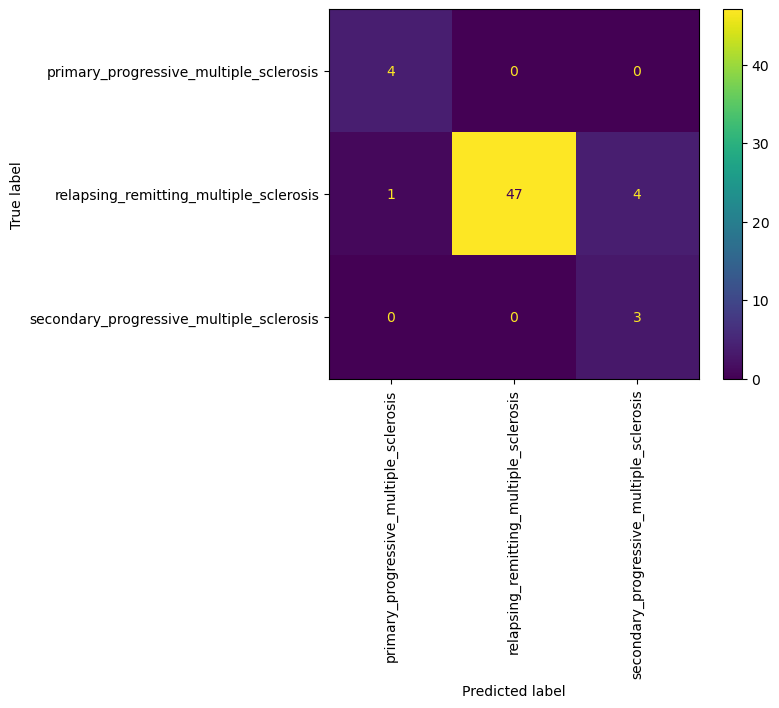

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='micro')}")
print(f"Precision: {precision_score(labels, predictions, average='weighted')}")
print(f"Recall: {recall_score(labels, predictions, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

In [17]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
for i, label in enumerate(labels):
    if label != predictions[i]:
        print("Entry: ", i)
        print("Label", id2label[label])
        print("Predicted", id2label[predictions[i]])
        print("Text: ", df_test.iloc[i]["text"])
        print("\n")

Entry:  1
Label relapsing_remitting_multiple_sclerosis
Predicted primary_progressive_multiple_sclerosis
Text:  Schubförmige Multiple Sklerose, gesichert nach McDonald-Kriterien 2010, EM 08/2012, ED 12/2013 INDENT EDSS aktuell 2.0 INDENT Aktuell: sensibles Defizit rechte untere Extremität INDENT Verlauf: INDENT 08/2012 Neuritis N. optici links (Visus rechts 1.25, links 0.6) INDENT 06/2012 Kribbelparästhesien im linken Arm (selbstlimitierend) INDENT 01/2014 Schub mit inkomplettem leichten sensomotorischen Hemisyndrom re. INDENT Diagnostisch: INDENT 08/2012 Lumbalpunktion: 1 Zelle / ul, Protein und Glukose im Normbereich,   Laktat leicht vermindert. OKBs fraglich positiv. INDENT 08/2012 immunologisches Screening (Ro/La, Anti-ds-DNA, ANCA; RF, Antiphospholipid-Ak), sowie HIV-, Lues-, Borrelien-, Hepatitis-Serologie unauffällig INDENT 08/2012 MRI Schädel: Neuritis nervi optici links, multiple Läsionen der weissen Substanz subependymal, juxtakortikal und kortikal sowie der Balkenstrahlung un

F1 Score: 0.9519151544382146
Precision: 0.9649122807017544
Recall: 0.9473684210526315


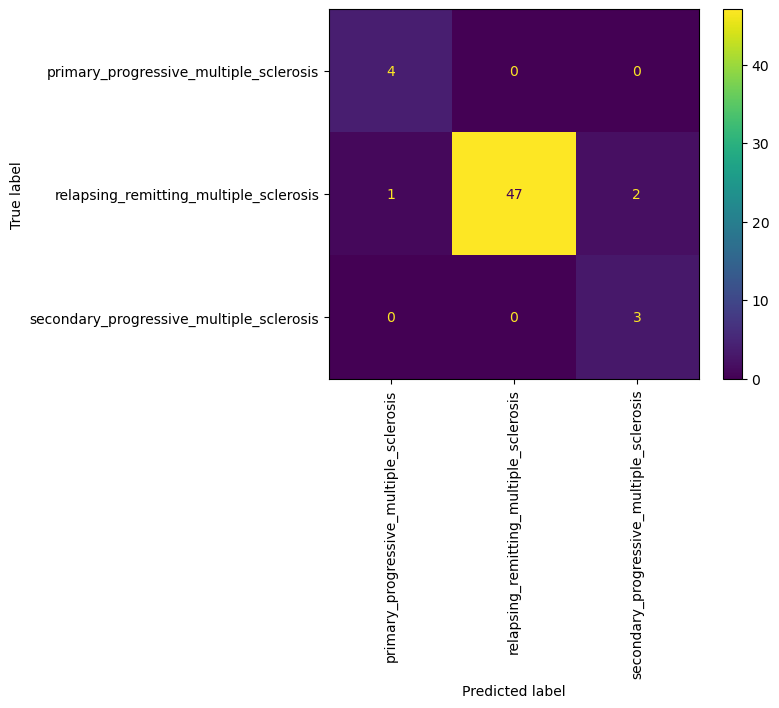

In [20]:
# Entry 3 is both RRMS and SPMS (so correct classification) and entry 56 is not MS
# Entries to be removed
entries_to_remove = [3, 56]

# Create a new list without the specified entries
predictions_corrected = [x for i, x in enumerate(predictions) if i not in entries_to_remove]
labels_corrected = [x for i, x in enumerate(labels) if i not in entries_to_remove]

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels_corrected, predictions_corrected, average='weighted')}")
print(f"Precision: {precision_score(labels_corrected, predictions_corrected, average='weighted')}")
print(f"Recall: {recall_score(labels_corrected, predictions_corrected, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels_corrected, predictions_corrected, display_labels=list(id2label.values()), xticks_rotation='vertical')